In [34]:
from __future__ import print_function, division
import sys,os
# line 4 and line 5 below are for development purposes and can be removed
qspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,qspin_path)
#####################################################################
#                            example 9                              #
#   In this script we demonstrate how to use QuSpin's               #
#   general basis class to construct user-defined symmetry sectors.	#
#   We study thermalisation in the 2D transverse-field Ising model  #
#   with periodic boundary conditions.                              #
#####################################################################
from quspin.operators import hamiltonian, exp_op # operators
from quspin.basis import spin_basis_1d, spin_basis_general # spin basis constructor
from quspin.tools.measurements import obs_vs_time # calculating dynamics
from quspin.tools.Floquet import Floquet_t_vec # period-spaced time vector
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
#
###### define model parameters ######
L_1d = 16 # length of chain for spin 1/2
Lx, Ly = 4, 4 # linear dimension of spin 1 2d lattice
N_2d = Lx*Ly # number of sites for spin 1

In [35]:
###### setting up user-defined symmetry transformations for 2d lattice ######
s = np.arange(N_2d) # sites [0,1,2,....]
x = s%Lx # x positions for sites
y = s//Lx # y positions for sites
T_x = (x+1)%Lx + Lx*y # translation along x-direction
T_x_inv = np.argsort(T_x)
T_y = x +Lx*((y+1)%Ly) # translation along y-direction

###### setting up bases ######
basis_1d = spin_basis_1d(L_1d,kblock=0,pblock=1,zblock=1) # 1d - basis
basis_2d = spin_basis_general(N_2d, S='1/2', pauli=0) # 2d - basis
# print information about the basis
print("Size of 1D H-space: {Ns:d}".format(Ns=basis_1d.Ns))
print("Size of 2D H-space: {Ns:d}".format(Ns=basis_2d.Ns))

Size of 1D H-space: 1162
Size of 2D H-space: 65536


In [36]:
a = 1
J = [0.3, a]

In [37]:
NN=[[J[0],i,T_x[i]] for i in range(N_2d)]+[[J[0],i,T_y[i]] for i in range(N_2d)]
NNN = [[J[1],i,T_y[T_x[i]]] for i in range(N_2d)]+[[J[1],i,T_y[T_x_inv[i]]] for i in range(N_2d)]

In [44]:
J1 = [[opstr, NN] for opstr in ["zz", "xx", "yy"]]
J2 = [[opstr, NNN] for opstr in ["zz", "xx", "yy"]]
H = hamiltonian(J1 + J2, [],basis=basis_2d,dtype=np.float64)
H_J1J2 = H.as_sparse_format()

Hermiticity check passed!


/tmp/ipykernel_19384/672290158.py:3: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_general.spin.spin_basis_general'>, to turn off this warning set check_symm=False in hamiltonian
  H = hamiltonian(J1 + J2, [],basis=basis_2d,dtype=np.float64)


In [47]:
E = H_J1J2.eigsh(return_eigenvectors=False, which="SA")
print(E)

[-10.17000314 -10.35258439 -11.02326761 -11.02326761 -11.02326761
 -12.02117043]


## finite temperature calculation

In [48]:
from __future__ import print_function, division
#
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='1' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='1' # set number of MKL threads to run in parallel
#
quspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,quspin_path)
#######################################################################
#                            example 21                               #    
# This example shows how to use the `Lanczos` submodule of the        #
# `tools` module to compute finite temperature expectation values     #
# using `FTLM_statc_iteration` and `LTLM_statiic_iteration`.          #
#######################################################################
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian,quantum_operator
from quspin.tools.lanczos import lanczos_full,lanczos_iter,FTLM_static_iteration,LTLM_static_iteration
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [49]:
def bootstrap_mean(O_r,Id_r,n_bootstrap=100):
    """
    Uses boostraping to esimate the error due to sampling.

    O_r: numerator
    Id_r: denominator
    n_bootstrap: bootstrap sample size

    """
    O_r = np.asarray(O_r)
    Id_r = np.asarray(Id_r)
    #
    avg = np.nanmean(O_r,axis=0)/np.nanmean(Id_r,axis=0)
    n_Id = Id_r.shape[0]
    #n_N = O_r.shape[0]
    #
    i_iter = (np.random.randint(n_Id,size=n_Id) for i in range(n_bootstrap))
    #
    bootstrap_iter = (np.nanmean(O_r[i,...],axis=0)/np.nanmean(Id_r[i,...],axis=0) for i in i_iter)
    diff_iter = ((bootstrap-avg)**2 for bootstrap in bootstrap_iter)
    err = np.sqrt(sum(diff_iter)/n_bootstrap)
    #
    return avg,err
class lanczos_wrapper(object):
    """
    Class that contains minimum requirments to use Lanczos. 
    
    Using it is equired, since the dot and dtype methods of quantum_operator objects take more parameters 
    
    """
    #
    def __init__(self,A,**kwargs):
        """
        A: array-like object to assign/overwrite the dot and dtype objects of
        kwargs: any optional arguments used when overwriting the methods

        """
        self._A = A
        self._kwargs = kwargs
    #
    def dot(self,v,out=None):
        """
        Calls the `dot` method of quantum_operator with the parameters fixed to a given value.

        """
        return self._A.dot(v,out=out,pars=self._kwargs)
    #
    @property
    def dtype(self):
        """
        The dtype attribute is required to figure out result types in lanczos calculations.

        """
        return self._A.dtype

In [50]:
L = 10 # system size
m = 50 # dimensio of Krylov space
N_samples = 100 # of samples to approximate thermal expectation value with
T = np.logspace(-3,3,51,base=10) # temperature vector
beta = 1.0/(T+1e-15) # inverse temperature vector
H_wrapped = lanczos_wrapper(H,J=s,h=(1-s))
[E0] = H.eigsh(k=1,which="SA",return_eigenvectors=False)
# preallocate lists to store results from iterations
out = np.zeros((m,H.Ns),dtype=np.float64)

In [51]:
r = np.random.normal(0,1,size=H.Ns)
r /= np.linalg.norm(r)
E,V,lv = lanczos_full(H,r,m,eps=1e-8,full_ortho=True)

In [52]:
M2_FT_list = []
M2_LT_list = []
Z_FT_list = []
Z_LT_list = []

for i in range(N_samples):
    r = np.random.normal(0,1,size=H.Ns)
    r /= np.linalg.norm(r)
    E,V,lv = lanczos_full(H,r,m,eps=1e-8,full_ortho=True)
    E -= E0
    results_FT,Id_FT = FTLM_static_iteration({"E":H},E,V,lv,beta=beta)
    results_LT,Id_LT = LTLM_static_iteration({"E":H},E,V,lv,beta=beta)
    # save results to a list
    M2_FT_list.append(results_FT["E"])
    Z_FT_list.append(Id_FT)
    M2_LT_list.append(results_LT["E"])
    Z_LT_list.append(Id_LT)

In [53]:
# calculating error bars on the expectation values
m2_FT,dm2_FT = bootstrap_mean(M2_FT_list,Z_FT_list)
m2_LT,dm2_LT = bootstrap_mean(M2_LT_list,Z_LT_list)
#
##### calculating exact results from full diagonalization #####
#
dim_cutoff=2000 # Hilbert space dimension cutoff  
if H.Ns < dim_cutoff: # Hilbert space is not too big to diagonalize on a laptop
    #
    # adding more points for smooth line
    T_new = np.logspace(np.log10(T.min()),np.log10(T.max()),10*len(T))
    beta_new = 1.0/(T_new+1e-15)
    #
    # full diagonaization of H
    E,V = H.eigh(pars=dict(J=s,h=1-s))
    # shift energy to avoid overflows
    E -= E[0]
    # get boltzmann weights for each temperature
    W = np.exp(-np.outer(E,beta_new))
    # get diagonal matrix elements for trace
    O = M2.matrix_ele(V,V,diagonal=True) 
    # calculate trace
    O = np.einsum("j...,j->...",W,O)/np.einsum("j...->...",W)

In [60]:
energy = dict(zip(T, m2_FT))

In [62]:
energy[1.0]

-7.7207803015753935

/tmp/ipykernel_19384/2480774326.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


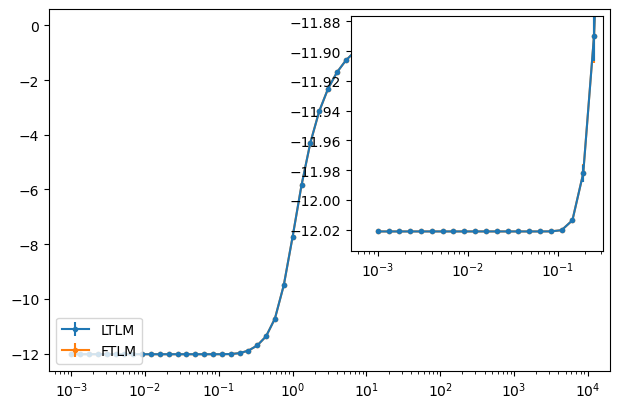

In [54]:
##### plot results #####
#
# setting up plot and inset
h=4.2 # figure aspect ratio parameter
f,ax = plt.subplots(figsize=(1.5*h,h))
axinset = inset_axes(ax, width="45%", height="65%", loc="upper right")
axs = [ax,axinset]
#
# plot results for FTLM and LTLM.
for a in axs:
    a.errorbar(T,m2_LT,dm2_LT,marker=".",label="LTLM",zorder=-1)
    a.errorbar(T,m2_FT,dm2_FT,marker=".",label="FTLM",zorder=-2)
    #
    if H.Ns < dim_cutoff: # hilbert space is not too big to diagonalize on a laptop
        a.plot(T_new,O,label="exact",zorder=0)
    #
    a.set_xscale("log")
#
# adding space for inset by expanding x limits.
xmin,xmax = ax.get_xlim()
ax.set_xlim((xmin,10*xmax))
ax.legend(loc="lower left")
#
# inset adjustment to zoom in low-temp limit.
xmin,xmax = axinset.get_xlim()
#
a = -0.6
m = np.logical_and(T>=xmin,T<=10**(a))
axinset.set_xlim((xmin,10**(a+0.1)))
ymin = min(m2_LT[m].min(),m2_FT[m].min())
ymax = max(m2_LT[m].max(),m2_FT[m].max())
ywin = ymax-ymin
boundy = 0.1*ywin
axinset.set_ylim((ymin-boundy,ymax+boundy))
#
# display plot
f.tight_layout()

In [ ]:
E0

-8.00000000000001